# Hough Transform

## Lines
http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html

### Hough Space
Hough transform converts points on the X-Y space to \rho \theta space like this
![Hough space](img/HoughLineSpace.png)

You can see that all the points boil down to a single intersect on the hough space. This is then our line... Refer to the opencv document on how the line is represented on the rho theta space

### Example code to find lanes from a road

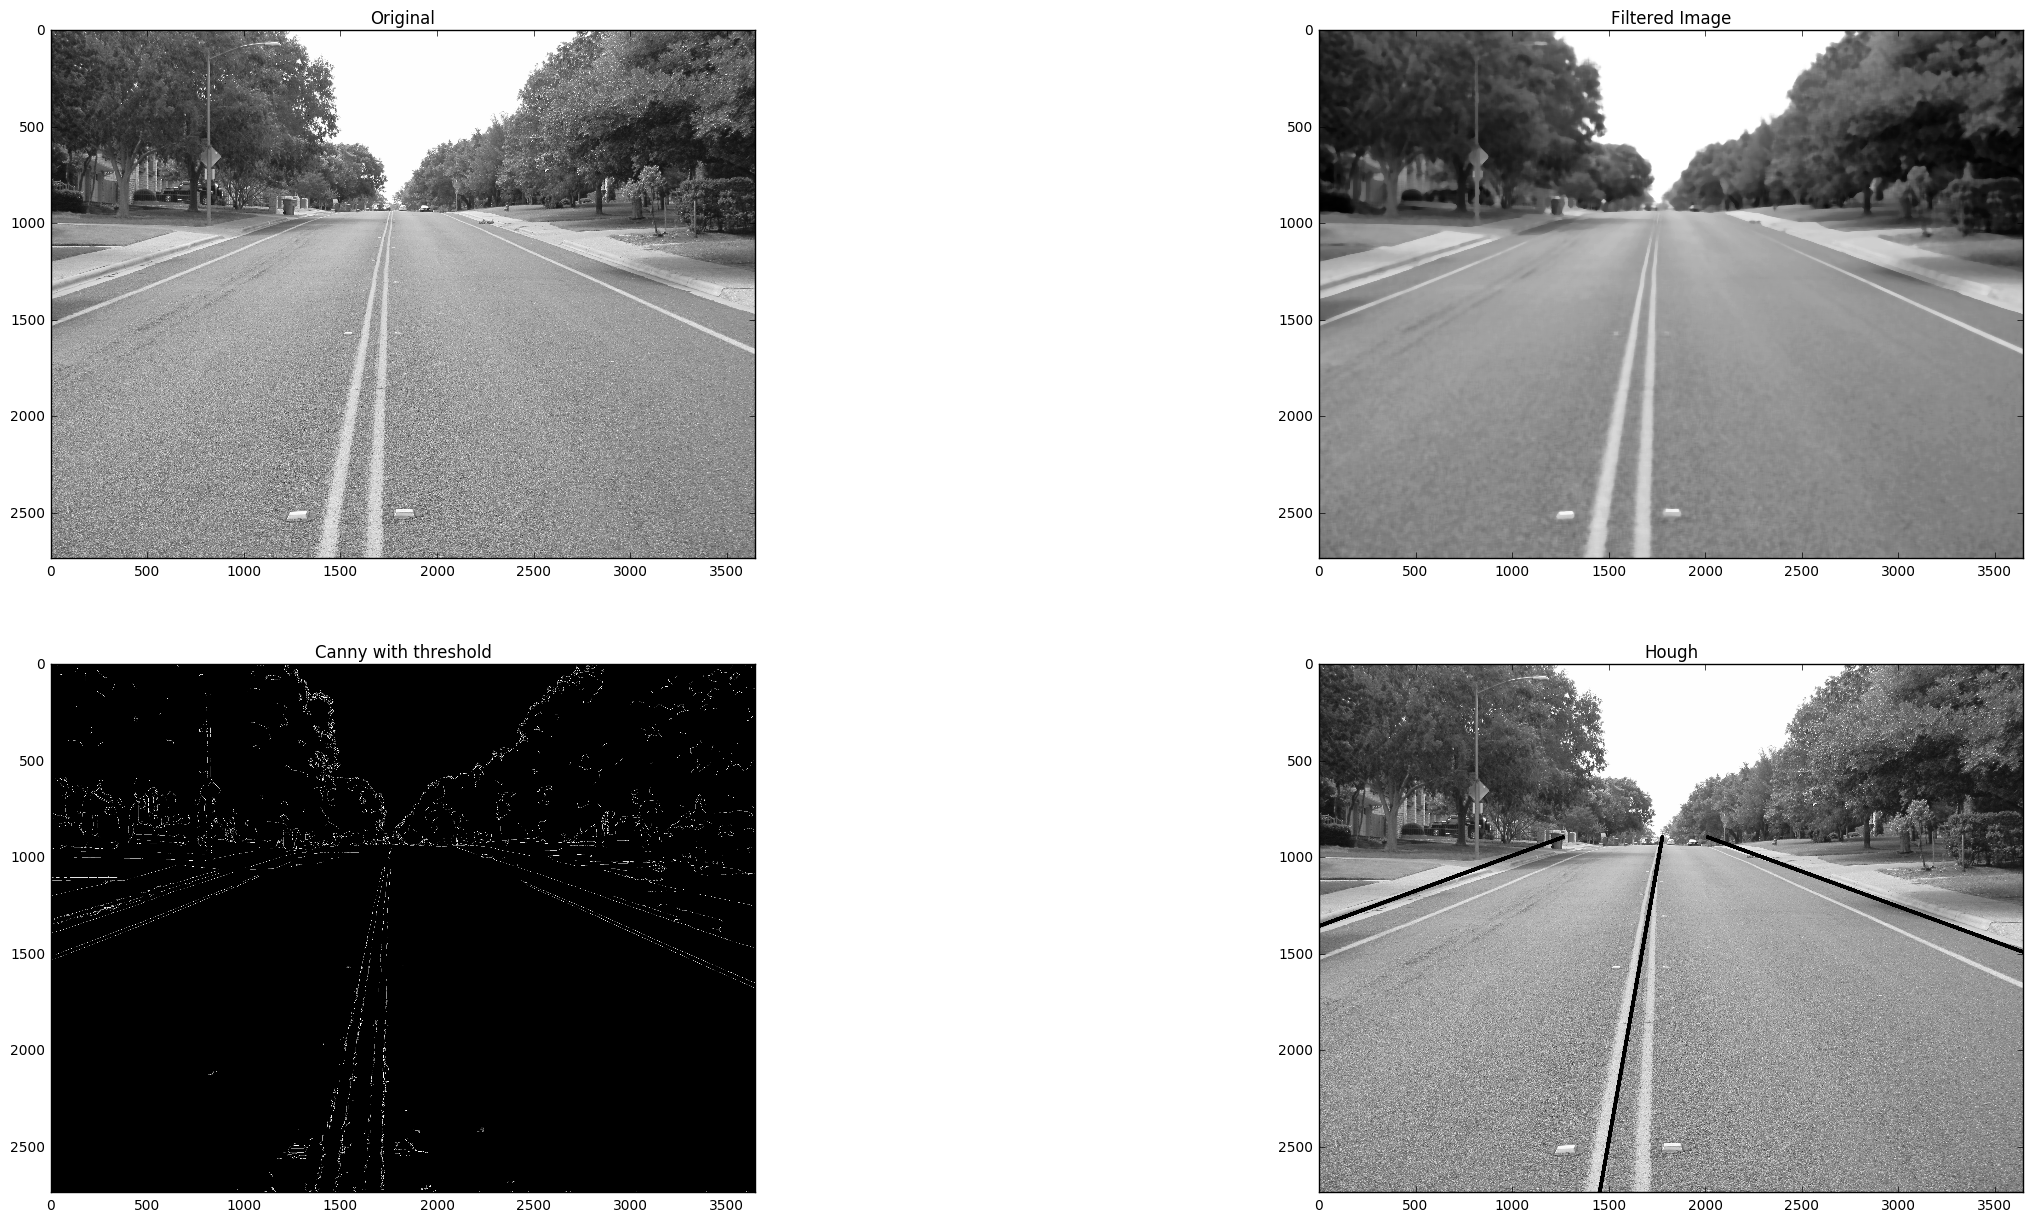

In [9]:
# Implementing a lane detector
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline 

HORIZON_Y = 900

LL_TMIN = 1.20
LL_TMAX = 1.23

ML_TMIN = 0.15
ML_TMAX = 0.19

RL_TMIN = 1.91
RL_TMAX = 1.93

def FormLine(rho, theta):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho

    if a >= 0:
        k = (y0 - HORIZON_Y) / a
        x1 = int(x0 + 5000*(-b))
        y1 = int(y0 + 5000*(a))
        x2 = int(x0 - k*(-b))
        y2 = int(y0 - k*(a))

    else:
        k = (HORIZON_Y - y0) / a
        x1 = int(x0 + k*(-b))
        y1 = int(y0 + k*(a))
        x2 = int(x0 - 5000*(-b))
        y2 = int(y0 - 5000*(a))
    
    return [x1, y1, x2, y2]

# Create a figure
fig = plt.figure(figsize=(30,15))

# Get the image
img = cv2.imread("lane.jpg",0)
a=fig.add_subplot(2,2,1)
imgplot = plt.imshow(img, cmap='Greys_r')
a.set_title('Original')

# Apply a median filter and try to clean the noise
filteredImg = cv2.medianBlur(img,25)
a=fig.add_subplot(2,2,2)
imgplot = plt.imshow(np.array(filteredImg), cmap='Greys_r')
a.set_title('Filtered Image')

# Apply a canny edge detector with thresholding
canny = cv2.Canny(filteredImg,0,35,apertureSize = 3)
retval, thresh = cv2.threshold(canny, 50, 255,cv2.THRESH_BINARY)
a=fig.add_subplot(2,2,3)
imgplot = plt.imshow(np.array(thresh), cmap='Greys_r')
a.set_title('Canny with threshold')

# Apply a hough line detector
LaneMarkings = np.copy(img)
lines = cv2.HoughLines(thresh,1,np.pi/18,150)
lanes = [[0.0,0.0,0.0,0.0] for x in range(3)]

# Resolve into 3 lanes
for line in lines:
    llmaxr = -5000
    mlmint = np.pi
    rlminr = 5000
    
    for rho,theta in line:
        # Get the left lane
        if ((theta > LL_TMIN) and (theta < LL_TMAX) and (rho > llmaxr)):
            llmaxr = rho
            lanes[0] = FormLine(rho, theta)
            
        elif ((theta > ML_TMIN) and (theta < ML_TMAX) and (theta < mlmint)):
            llmint = theta
            lanes[1] = FormLine(rho, theta)
            
        elif ((theta > RL_TMIN) and (theta < RL_TMAX) and (rho < rlminr)):
            rlminr = rho
            lanes[2] = FormLine(rho, theta)

# Augment the lanes onto the image
for lane in lanes:
    cv2.line(LaneMarkings,(lane[0],lane[1]),(lane[2],lane[3]),0,20)
a=fig.add_subplot(2,2,4)
imgplot = plt.imshow(np.array(LaneMarkings), cmap='Greys_r')
a.set_title('Hough')

# Show all the images
plt.show()
    

## Circles
* Transforms (x-a)<sup>2</sup> + (y-b)<sup>2</sup> = r<sup>2</sup> from X-Y space into A-B-R (3D) space
* Because this is 3-D, the computational complexity is incredibly high
* When the gradients are known, we know that the center can only be perpendicular to the gradient at any given point, so the voting is simply in a line. Like this
* Optimize the bins a lot as that matters a lot

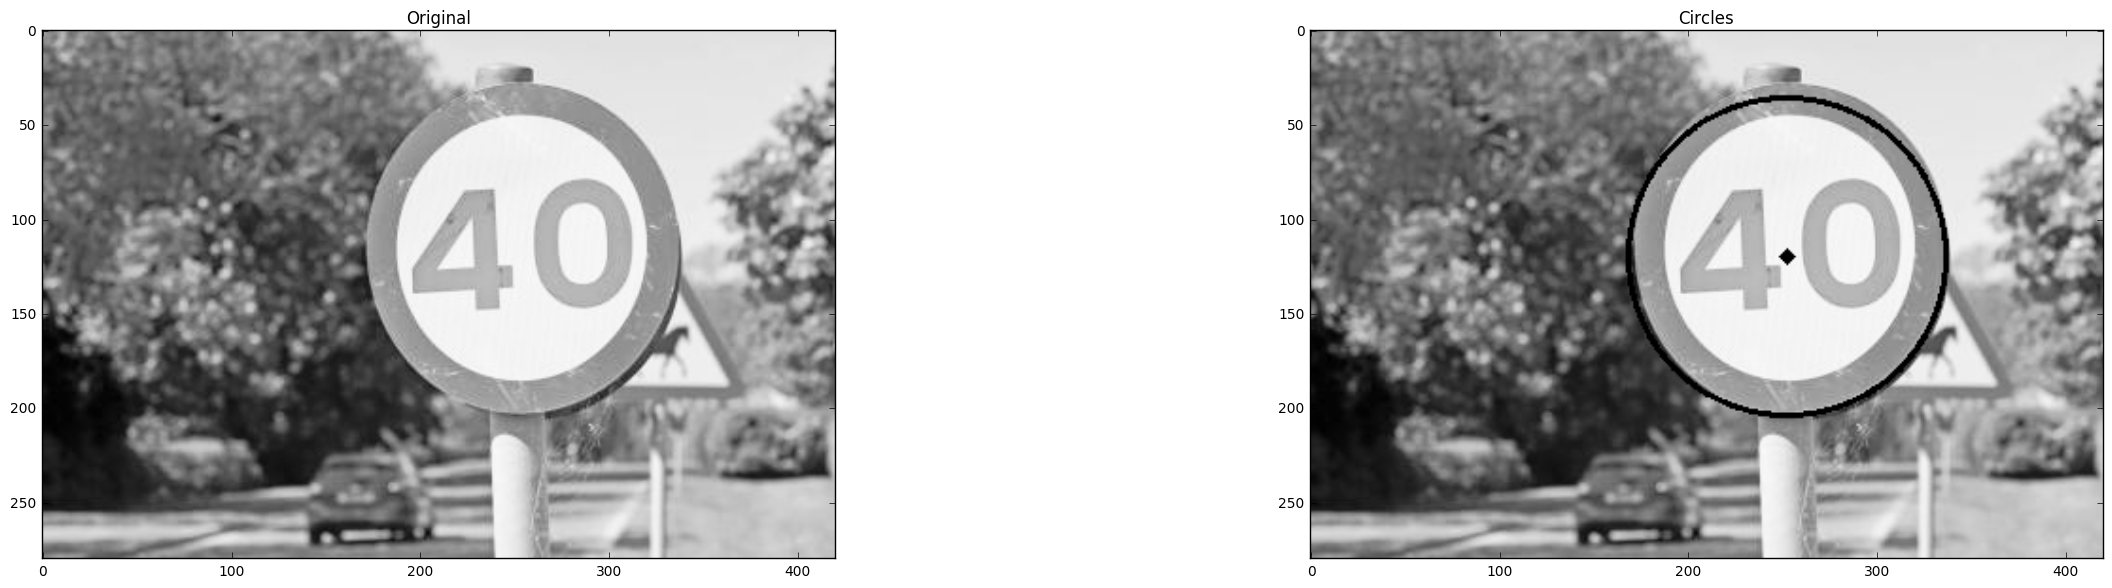

In [8]:
# Implement a traffic sign detection
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline 

# Create a figure
fig = plt.figure(figsize=(30,15))

# Get the image
img = cv2.imread("TraSign.jpg",0)
a=fig.add_subplot(2,2,1)
imgplot = plt.imshow(img, cmap='Greys_r')
a.set_title('Original')

# Find the circles
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,100,param1=100,param2=80,minRadius=60,maxRadius=300)

# Paint the circles
cimg = np.copy(img)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
a=fig.add_subplot(2,2,2)
imgplot = plt.imshow(cimg, cmap='Greys_r')
a.set_title('Circles')

# Show all the images
plt.show()

# Pros / Cons of Hough in general
* Pros 
  * Occulsion is ok as each point votes independantly
  * Some robustness towards noise
  * Can detect multiple instances of the object in a single run
  
* Cons
  * Complexity
  * Non target space can produce very weird results

# Generalized Hough Transform
* Going to use non-analytical models: no use of a generic parameter space but rather express parameters in terms of scale and orintation of a custom template
* Visual code word: which are features that we will try to extract templates from the models. This is very modern.

## Generalized Hough Algorithm
### Training
* Fix a point within the template as it's center
* From every edge point on the template, compute the displacement r = c - p<sub>i</sub>
* Measure the gradient at each point
* Place the r in a table (aka Hough Table) indexed by gradients

### Recognition
* At each boundary point on the test image, measure the gradient
* Look up the r's for that particular gradient, and vote for a center to be placed at each r from that point

### Demo
https://www.youtube.com/watch?v=QJWDNAOxiNc

### Notes
* When the orientation can change, just add another loop to loop through all the possible orientations during the voting. The gradient needs to be adjusted with the orientation variable now
* The same idea applies for if the scale has changed. This time, the r is modified by the scale variable.

## Visual Codeword
* Idea is to have features from the object that are easy to find (say tires in car sideways)
* Train a Hough table that has features with gradient and displacement instead of edges
* During recognition, if the image has the same features with similar gradient and displacement from the object center, you can detect the object, without having the train the hough table on the entire object
* Idea is to detect a car with just the two wheels rather than trying to get the entire car into a hough table and wasting resources.
  * The tires can be found with a simple HoughCircle..
